Data was taken from [Kaggle](https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from backend.util.dataloader import get_data_loaders
from backend.model.train import train_and_validate
from backend.model.model import CardClassifier

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: {}".format(device))

Using device: cpu


In [3]:
# Load data
train_dir = '../data/train'
valid_dir = '../data/valid'
test_dir = '../data/test'
batch_size = 32
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_loader, valid_loader, test_loader, target_to_class = get_data_loaders(
    train_dir, valid_dir, test_dir, batch_size, transform
)

In [8]:
# Save target_to_class to JSON to access it later when outputting predictions

"""
import json
with open('target_to_class.json', 'w') as file:
    json.dump(target_to_class, file, indent=4)
 
""" 

"\nimport json\nwith open('target_to_class.json', 'w') as file:\n    json.dump(target_to_class, file, indent=4)\n \n"

In [69]:
num_epochs = 25
momentum = 0.9
lr = 0.001

model = CardClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum )

results = train_and_validate(model, criterion, optimizer, train_loader, valid_loader, device, num_epochs=num_epochs)

Epoch 1/30
Training Loss: 3.6404, Training Accuracy: 11.70%
Validation Loss: 3.0984, Validation Accuracy: 21.89%
Epoch 2/30
Training Loss: 2.6346, Training Accuracy: 36.70%
Validation Loss: 2.0282, Validation Accuracy: 47.17%
Epoch 3/30
Training Loss: 1.8928, Training Accuracy: 53.87%
Validation Loss: 1.4305, Validation Accuracy: 67.92%
Epoch 4/30
Training Loss: 1.4630, Training Accuracy: 63.52%
Validation Loss: 1.0630, Validation Accuracy: 74.34%
Epoch 5/30
Training Loss: 1.1577, Training Accuracy: 71.29%
Validation Loss: 0.7711, Validation Accuracy: 81.13%
Epoch 6/30
Training Loss: 0.9253, Training Accuracy: 76.53%
Validation Loss: 0.5790, Validation Accuracy: 85.28%
Epoch 7/30
Training Loss: 0.7555, Training Accuracy: 80.60%
Validation Loss: 0.5146, Validation Accuracy: 85.28%
Epoch 8/30
Training Loss: 0.6181, Training Accuracy: 84.46%
Validation Loss: 0.4440, Validation Accuracy: 86.79%
Epoch 9/30
Training Loss: 0.5003, Training Accuracy: 87.34%
Validation Loss: 0.3821, Validation 

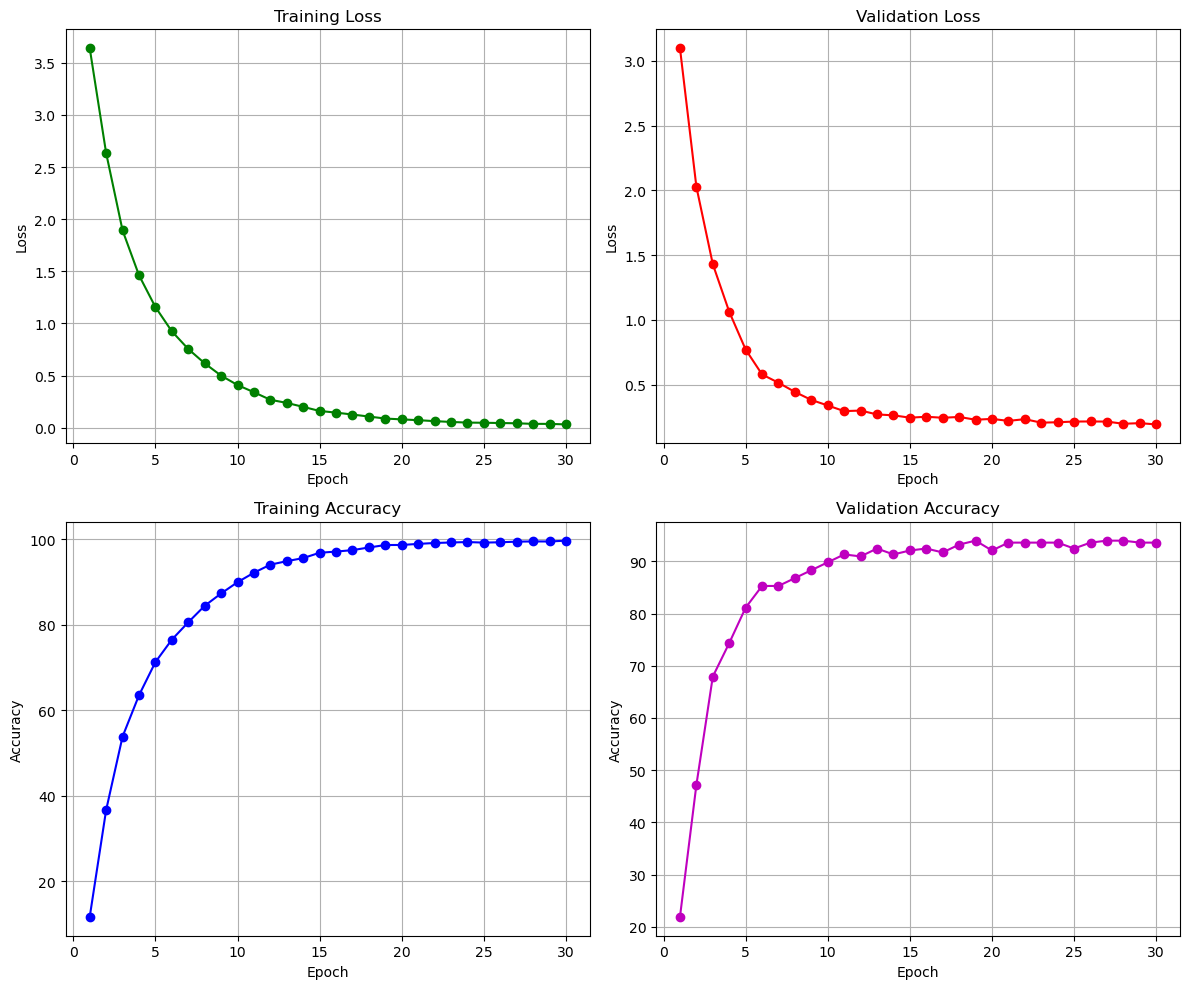

In [70]:
train_losses, val_losses, train_accuracies, val_accuracies = results
epochs = list(range(1, len(train_losses) + 1))

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot training loss
ax[0, 0].plot(epochs, train_losses, 'go-', label='Training Loss')
ax[0, 0].set_title('Training Loss')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].grid(True)

# Plot validation loss
ax[0, 1].plot(epochs, val_losses, 'ro-', label='Validation Loss')
ax[0, 1].set_title('Validation Loss')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].grid(True)

# Plot training accuracy
ax[1, 0].plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
ax[1, 0].set_title('Training Accuracy')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Accuracy')
ax[1, 0].grid(True)

# Plot validation accuracy
ax[1, 1].plot(epochs, val_accuracies, 'mo-', label='Validation Accuracy')
ax[1, 1].set_title('Validation Accuracy')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Accuracy')
ax[1, 1].grid(True)

# Show plots
plt.tight_layout()  
plt.show()

In [71]:
torch.save(model.state_dict(), 'model_card_classifier.pth')